In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
tf.__version__

'1.12.0'

mnist


In [60]:
#from python-mnist import MNIST
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('./model_data', one_hot=True)

Extracting ./model_data/train-images-idx3-ubyte.gz
Extracting ./model_data/train-labels-idx1-ubyte.gz
Extracting ./model_data/t10k-images-idx3-ubyte.gz
Extracting ./model_data/t10k-labels-idx1-ubyte.gz


In [61]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Validation-set:\t{}".format(len(data.test.labels)))
print("- Test-set:\t\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Validation-set:	10000
- Test-set:		5000


In [62]:
data.test.cls = np.argmax(data.test.labels, axis=1)

In [63]:
img_size = 28

img_size_flat = 28*28

img_shape = (img_size,img_size)

num_channels = 1

num_classes = 10

In [64]:
#helper function to plot images
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    #create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred {1}".format(cls_true[i], cls_pred[i])
            
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

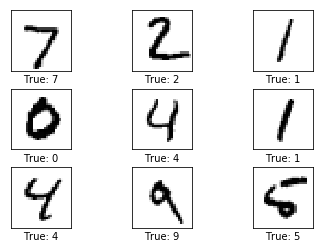

array([7, 2, 1, 0, 4, 1, 4, 9, 5])

In [65]:
images = data.test.images[0:9]

cls_true = data.test.cls[0:9]

plot_images(images=images, cls_true=cls_true)
cls_true

In [66]:
#initializing graph with random weights
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [67]:
#helper function to create new CNN layer as tensorflow is complicated
def new_conv_layer(input,  #prev layer
                   num_input_channels, #n channels from prev layer
                   filter_size,        #width and height
                   num_filters,
                   use_pooling=True,    #use 2x2 max pooling
                   use_dropout=False
                  ):
    #shape of filter weights for conv
    #this format determined by TensorFlow API
    shape = [filter_size, filter_size,num_input_channels, num_filters]
    
    weights = new_weights(shape=shape)
    
    biases = new_biases(length=num_filters)
    
    layer = tf.nn.conv2d(input=input, 
                        filter=weights,
                        strides=[1,1,1,1],
                        padding='SAME')
    layer += biases
    
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                              ksize=[1,2,2,1],
                              strides=[1,2,2,1],
                              padding='SAME')
    
    layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer, 0.1)
    
    return layer, weights

In [68]:
def flatten_layer(layer):

    layer_shape = layer.get_shape()
    
    num_features = np.array(layer_shape[1:4], dtype=int).prod()
    
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features
    

In [69]:
def new_fc_layer(input, 
                num_inputs,
                num_outputs,
                use_relu=True):
    weights=new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

In [75]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Convolutional Layer 3.
filter_size3 = 3          # Convolution filters are 5 x 5 pixels.
num_filters3 = 64         # There are 36 of these filters.

In [76]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [77]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [78]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

In [79]:
y_true_cls = tf.argmax(y_true, dimension=1)

In [80]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                           num_input_channels=num_channels,
                                           filter_size=filter_size1,
                                           num_filters=num_filters1,
                                           use_pooling=True,
                                           use_dropout=False)

In [81]:
layer_conv1

<tf.Tensor 'Relu_6:0' shape=(?, 14, 14, 16) dtype=float32>

In [82]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                           num_input_channels=num_filters1,
                                           filter_size=filter_size2,
                                           num_filters=num_filters2,
                                           use_pooling=True, 
                                           use_dropout=False)

In [83]:
layer_conv2

<tf.Tensor 'Relu_7:0' shape=(?, 7, 7, 36) dtype=float32>

In [84]:
layer_conv3, weights_conv3 = new_conv_layer(input=layer_conv2,
                                           num_input_channels=num_filters2,
                                           filter_size=filter_size3,
                                           num_filters=num_filters3,
                                           use_pooling=True, 
                                           use_dropout=False)

In [85]:
layer_conv3

<tf.Tensor 'Relu_8:0' shape=(?, 4, 4, 64) dtype=float32>

In [87]:
layer_conv4, weights_conv4 = new_conv_layer(input=layer_conv3,
                                           num_input_channels=num_filters3,
                                           filter_size=filter_size3,
                                           num_filters=num_filters3,
                                           use_pooling=True, 
                                           use_dropout=False)
layer_conv4

<tf.Tensor 'Relu_9:0' shape=(?, 2, 2, 64) dtype=float32>

In [88]:
layer_flat, num_features = flatten_layer(layer_conv4)

In [89]:
layer_flat

<tf.Tensor 'Reshape_4:0' shape=(?, 256) dtype=float32>

In [90]:
num_features

256

In [93]:
# Fully-connected layer.
fc_size = 512             # Number of neurons in fully-connected layer.
fc_size1 = 128
fc_size2 = 64

In [94]:
layer_fc1 = new_fc_layer(input=layer_flat,
                        num_inputs=num_features,
                        num_outputs=fc_size,
                        use_relu=True
                        )
layer_fc1

<tf.Tensor 'Relu_11:0' shape=(?, 512) dtype=float32>

In [95]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                        num_inputs=fc_size,
                        num_outputs=fc_size1,
                        use_relu=True
                        )
layer_fc2

<tf.Tensor 'Relu_12:0' shape=(?, 128) dtype=float32>

In [96]:
layer_fc3 = new_fc_layer(input=layer_fc2,
                        num_inputs=fc_size1,
                        num_outputs=fc_size2,
                        use_relu=True
                        )
layer_fc3

<tf.Tensor 'Relu_13:0' shape=(?, 64) dtype=float32>

In [97]:
layer_fc4 = new_fc_layer(input=layer_fc3,
                        num_inputs=fc_size2,
                        num_outputs=num_classes,
                        use_relu=False)
                        
layer_fc4

<tf.Tensor 'add_14:0' shape=(?, 10) dtype=float32>

In [98]:
"""layer_fc4 = new_fc_layer(input=layer_fc3,
                        num_inputs=fc_size2,
                        num_outputs=num_classes,
                        use_relu=False)
layer_fc4
"""

'layer_fc4 = new_fc_layer(input=layer_fc3,\n                        num_inputs=fc_size2,\n                        num_outputs=num_classes,\n                        use_relu=False)\nlayer_fc4\n'

In [99]:
y_pred = tf.nn.softmax(layer_fc4)

In [100]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [101]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc4, labels=y_true)

In [102]:
cost = tf.reduce_mean(cross_entropy)

In [103]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost) #0.0001

In [104]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [105]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [106]:
session = tf.Session()

In [107]:
session.run(tf.initialize_all_variables())

In [108]:
train_batch_size = 64

In [109]:
total_iterations = 0

def optimize(num_iterations):
    global total_iterations
    
    start_time = time.time()
    
    for i in range(total_iterations,
                  total_iterations+num_iterations):
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        
        feed_dict_train = {x: x_batch,
                          y_true: y_true_batch}
        
        session.run(optimizer, feed_dict=feed_dict_train)
        
        if i%100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            
            print(msg.format(i+1, acc))
            
        total_iterations += num_iterations

        end_time = time.time()

        time_dif = end_time - start_time

    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
        

In [110]:
def plot_example_errors(cls_pred, correct):
    
    incorrect = (correct==False)
    
    images = data.test.images[incorrect]
    
    cls_pred = cls_pred[incorrect]
    
    cls_true = data.test.cls[incorrect]
    
    plot_images(images=images[0:9],
               cls_true=cls_true[0:9],
               cls_pred=cls_pred[0:9])
    

In [111]:
def plot_confusion_matrix(cls_pred):
    
    cls_true = data.test.cls
    
    cm = confusion_matrix(y_true=cls_true,
                         y_pred=cls_pred)
    
    print(cm)
    
    plt.matshow(cm)
    
    plt.colorbar()
    
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

In [112]:
#lower test batch size if crashes, to something like 50
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                       show_confusion_matrix=False):
    
    num_test = len(data.test.images)
    
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    i=0
    
    while i < num_test:
        j=min(i + test_batch_size, num_test)
        
        #images = data.x_test[i:j, :]
        images = data.test.images[i:j, :]
        
        #labels = data.y_test[i:j, :]
        labels = data.test.labels[i:j, :]
        
        feed_dict = {x:images, y_true:labels}
        
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        
        i=j
        
    # Convenience variable for the true class-numbers of the test-set.
    #data.test.cls = np.argmax(data.test.labels, axis=1)
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)
    
    
    

In [113]:
print_test_accuracy()

Accuracy on Test-Set: 11.3% (1135 / 10000)


In [114]:
#do 1 optimisation iteration
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:   6.2%
Time usage: 0:00:00


In [115]:
print_test_accuracy()

Accuracy on Test-Set: 11.3% (1135 / 10000)


In [116]:
optimize(num_iterations=99)

Time usage: 0:00:04


Accuracy on Test-Set: 26.4% (2636 / 10000)
Example errors:


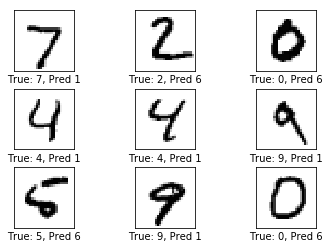

In [ ]:
#print miss-classified
print_test_accuracy(show_example_errors=True)

In [ ]:
optimize(num_iterations=900)

Optimization Iteration:   9901, Training Accuracy:  70.3%
Optimization Iteration:  10001, Training Accuracy:  79.7%
Optimization Iteration:  10101, Training Accuracy:  84.4%
Optimization Iteration:  10201, Training Accuracy:  84.4%
Optimization Iteration:  10301, Training Accuracy:  93.8%
Optimization Iteration:  10401, Training Accuracy:  92.2%
Optimization Iteration:  10501, Training Accuracy:  92.2%
Optimization Iteration:  10601, Training Accuracy:  93.8%
Optimization Iteration:  10701, Training Accuracy:  90.6%
Time usage: 0:00:33


Accuracy on Test-Set: 92.6% (9260 / 10000)
Example errors:


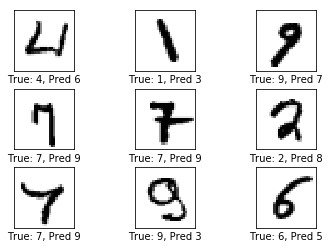

In [ ]:
print_test_accuracy(show_example_errors=True)

In [ ]:
optimize(num_iterations=10000)

Optimization Iteration: 819901, Training Accuracy:  90.6%
Optimization Iteration: 820001, Training Accuracy:  92.2%
Optimization Iteration: 820101, Training Accuracy:  93.8%
Optimization Iteration: 820201, Training Accuracy:  92.2%
Optimization Iteration: 820301, Training Accuracy:  92.2%
Optimization Iteration: 820401, Training Accuracy:  93.8%
Optimization Iteration: 820501, Training Accuracy:  95.3%
Optimization Iteration: 820601, Training Accuracy:  96.9%
Optimization Iteration: 820701, Training Accuracy:  95.3%
Optimization Iteration: 820801, Training Accuracy:  96.9%
Optimization Iteration: 820901, Training Accuracy:  93.8%
Optimization Iteration: 821001, Training Accuracy:  92.2%
Optimization Iteration: 821101, Training Accuracy:  95.3%
Optimization Iteration: 821201, Training Accuracy:  92.2%
Optimization Iteration: 821301, Training Accuracy:  96.9%
Optimization Iteration: 821401, Training Accuracy:  98.4%
Optimization Iteration: 821501, Training Accuracy:  95.3%
Optimization I

In [ ]:
print_test_accuracy(show_example_errors=True,
                   show_confusion_matrix=True)    

In [58]:
session.close()